# CNN

In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. In this part, we will use multiple filters of different sizes which will look at the bi-grams (a 1x2 filter), tri-grams (a 1x3 filter) and/or n-grams (a 1x$n$ filter) within the text.

The intuition here is that the appearance of certain bi-grams, tri-grams and n-grams within the text will be a good indication of the news group.

In [1]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234 #3 or 5 times - average results
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [2]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.1.1', '0.7.1', '0.16.1')

In [ ]:
# torch.cuda.get_device_name(0)

## 1. ETL: Loading the dataset

In [3]:
from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [4]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [5]:
#let's take a look at one example of train
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [6]:
#let's change the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

/Users/chaklam/Github/Natural-Language-Processing/chakyenv/lib/python3.9/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


{1, 2, 3, 4}

In [7]:
train_size = len(list(iter(train)))
train_size

120000

Since 120000 gonna just take up too much of our GPU, and also for the sake of learning, we gonna resize it.....  All `DataPipe` instance has a handy function called `random_split`

In [8]:
too_much, train, valid = train.random_split(total_length=train_size, 
                                            weights = {"too_much": 0.7, "smaller_train": 0.2, 
                                                       "valid": 0.1}, seed=999)

In [9]:
train_size = len(list(iter(train)))
train_size

24000

In [10]:
val_size = len(list(iter(valid)))
val_size

12000

In [11]:
test_size = len(list(iter(test)))
test_size

7600

## 3. Preprocessing 

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [12]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

/Users/chaklam/Github/Natural-Language-Processing/chakyenv/lib/python3.9/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/Users/chaklam/Github/Natural-Language-Processing/chakyenv/lib/python3.9/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

### Text to integers (numeral)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [13]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [14]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[509, 27, 9, 0, 9]

In [15]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'here'

In [16]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [17]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [18]:
#so we can 50k+ unique vocabularies!
len(vocab)

52828

## 4. FastText Embeddings

In [19]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

.vector_cache/wiki.simple.vec: 293MB [00:05, 52.4MB/s]                              
100%|██████████| 111051/111051 [00:07<00:00, 15836.43it/s]


In [20]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [21]:
fast_embedding.shape   #we have X vocabs, each with a 300 fasttext embedding

torch.Size([52828, 300])

## 4. Preparing the dataloader

In torchtext, first thing before the batch iterator is to define how you want to process your text and label.  

In [22]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

Let's look at example how it looks

In [23]:
text_pipeline("I love to play football")

[275, 4021, 8, 389, 574]

In [24]:
label_pipeline('1')

0

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.  **Since we are using CNN, we don't need the lengths which are needed for LSTM when we use pad_packed_sequence**.

In [25]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] 

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

Create train, val, and test dataloaders

In [26]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.  Note that {“World”, “Sports”, “Business”, “Sci/Tech”} maps to {0, 1, 2, 3}

In [27]:
for label, text in train_loader:
    break

In [28]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 141])


## 5. Design the model

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. 

Consider the 2 dimensional representation of the embedded sentence below:

<img src = "../figures/sentiment9.png">

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. 

Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a **[4x5]** "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. 

The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

<img src = "../figures/sentiment12_2.png" width=500>

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated. 

<img src = "../figures/sentiment13.png">

Finally, the filter moves down again and the final output for this filter is calculated.

<img src = "../figures/sentiment14.png">

In our case , our output will be a vector with number of elements equal to the height of the image (or length of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for classification.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

<img src = "../figures/sentiment15.png">

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[0], emb_dim))
        
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[1], emb_dim))
        
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[2], emb_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch_size, seq len]
        #1. embed
        embedded = self.embedding(text)
        #embedded = [batch_size, seq len, emb_size]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch_size, 1, seq len, emb_size]
        #2. convolute
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        #before squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1, 1]
        #after  squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1]
        
        #3. maxpool
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        #before squeeze = [batch_size, n_filters, 1]
        #after  squeeze = [batch_size, n_filters]
        
        #dropout
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        
        #4. fc
        return self.fc(cat)

### Let's see how each layer works

In [30]:
batch_size, seq_len = 64, 456
input_dim = len(vocab)

input_test = torch.randint(1, input_dim, (batch_size, seq_len))

In [38]:
embed = nn.Embedding(input_dim, 300)

In [39]:
embedded = embed(input_test)

In [40]:
embedded.shape #[batch_size, seq len, emb_size]

torch.Size([64, 456, 300])

In [41]:
embedded = embedded.unsqueeze(1)

In [42]:
embedded.shape

torch.Size([64, 1, 456, 300])

In [43]:
n_filters = 100
filter_sizes = [3, 4, 5]
emb_dim   = 300
conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[0], emb_dim))

In [44]:
conved_0 = F.relu(conv_0(embedded).squeeze(3))

In [45]:
conved_0.shape #conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1]

torch.Size([64, 100, 454])

In [46]:
pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)

In [47]:
pooled_0.shape

torch.Size([64, 100])

In [48]:
a = torch.cat((pooled_0, pooled_0, pooled_0), dim=1)

In [49]:
a.shape

torch.Size([64, 300])

### Using `nn.ModuleList`

In [ ]:
class CNN(nn.Module): #more elegant version
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
                
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, emb_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

### Using `nn.Conv1d`

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

<img src = "../figures/conv1d.png">

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested. 

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = emb_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

## 6. Training

In [50]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [51]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w)

tensor([[ 0.3513,  1.0135,  0.4421,  0.6361, -0.4714],
        [ 0.1078, -0.4170, -0.1532,  0.4345, -0.9875],
        [-0.0856,  1.8627, -0.1393, -0.7121, -0.0525]])

In [52]:
input_dim  = len(vocab)
emb_dim    = 300
output_dim = 4 #four classes

#for cnn
dropout = 0.5
n_filters = 100
filter_sizes = [3, 4, 5]

model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [53]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

15848400
 90000
   100
120000
   100
150000
   100
  1200
     4
______
16209904


As you can see, a lot of the complexity resides in the embedding layer.  In the future, we shall use some pretrained embeddings to fix this complexity.

In [54]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [55]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [56]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [57]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Putting everything together

In [58]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

/Users/chaklam/Github/Natural-Language-Processing/chakyenv/lib/python3.9/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [59]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [62]:
best_valid_loss = float('inf')
num_epochs      = 2

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 57s
	Train Loss: 1.487 | Train Acc: 29.40%
	 Val. Loss: 1.301 |  Val. Acc: 45.30%
Epoch: 02 | Time: 1m 0s
	Train Loss: 1.433 | Train Acc: 31.88%
	 Val. Loss: 1.256 |  Val. Acc: 54.59%


Text(0, 0.5, 'loss')

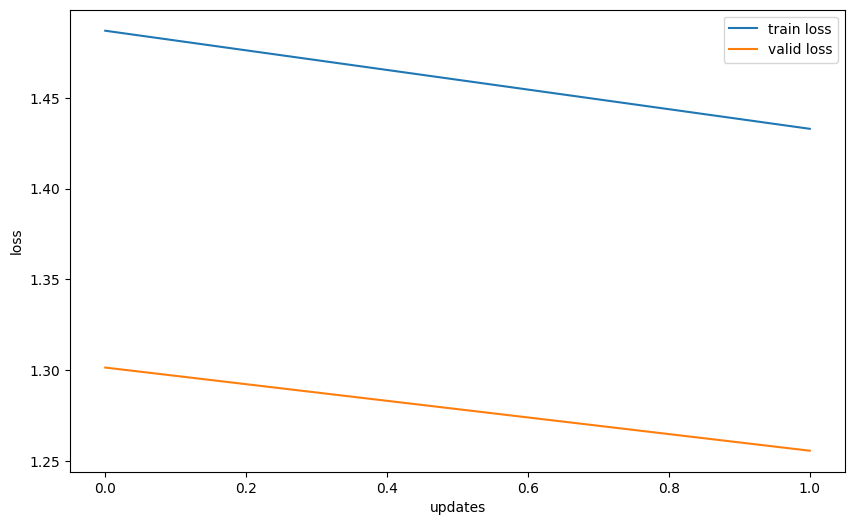

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

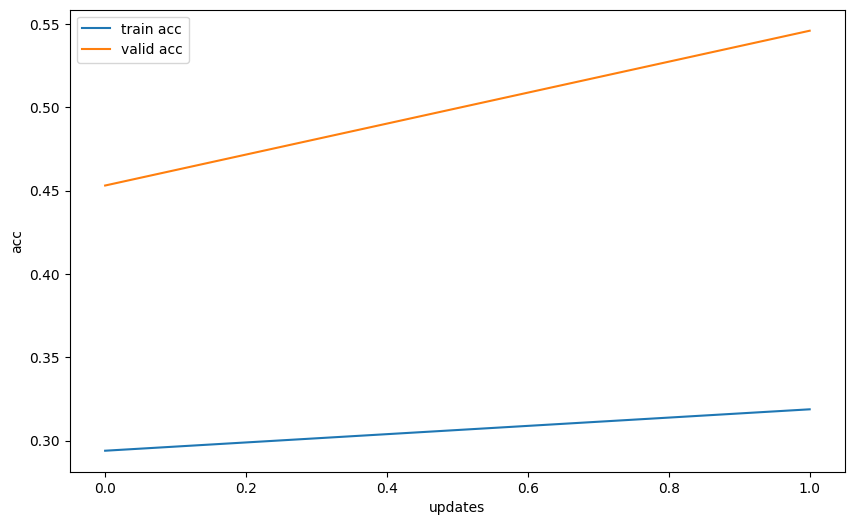

In [64]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [65]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.253 | Test Acc: 53.51%


## 7. Test on some random news

In [66]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  190,    27,   231,  1742, 14918,     6,    16,    21,   358,    27,
         2561,  1316,   231,     6])

In [67]:
text_list = [x.item() for x in text]
text_list

[190, 27, 231, 1742, 14918, 6, 16, 21, 358, 27, 2561, 1316, 231, 6]

In [68]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [69]:
text = text.reshape(1, -1)  #because batch_size is 1

In [70]:
text.shape

torch.Size([1, 14])

In [71]:
def predict(text):
    with torch.no_grad():
        output = model(text).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [72]:
predict(text) #0, 1, 2 = technology, 3

tensor([1])